# Manipulated Network Pt.2  

## 4 - Network Bending
### 4.1 Preparation  

First, we'll load the original model and load the weights.

In [1]:
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.backend import clear_session

from tensorflow import config


physical_devices = config.list_physical_devices('GPU')
config.experimental.set_memory_growth(physical_devices[0], True)
print(physical_devices)

import numpy as np
import pickle

from stylegan import StyleGAN_G


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
model = StyleGAN_G(resolution=1024)

all_weights = pickle.load(open('gs_weights_ffhq.pkl', 'rb'))
print('Weights loaded to memory.')

from stylegan import copy_weights_to_keras_model

copy_weights_to_keras_model(model.model_mapping, all_weights, console=True)
copy_weights_to_keras_model(model.model_synthesis, all_weights, console=True)
model.copy_weights(all_weights)

rnd = np.random.RandomState(28526)
latents = rnd.randn(1, 512)

Model created.
Weights loaded to memory.
.........Total number of parameters copied: 2101760
..........................................................................................Total number of parameters copied: 26381651


In the file `NetworkOperations.py`, I prepared 14 basic operations that could be inserted after specific model layers.   
The implemented StyleGAN model takes a dictionary variable as an operation template.  

`resolution` and `install_after` together define the Conv layer that is going to be operated. In the StyleGAN architecture, each resolution has two convolutional layers, `Conv0_up` is the one that scale up the feature maps, `Conv1` is the accompanied layer after the upscaling layer.  

`layers` defines a list of bending operations that is going to be inserted.  

`operation` takes a string defining the type of operation, including `scale`, `invert`, `shuffle`, `brightness`, `translate`, `vanish`, `mean_filter`, `rotate`, `sharpen`, `erosion`, `dilation`, `mirrorY`, `sin_disrupt`.

In [5]:
operations = [{'resolution':4,
               'install_after':'Conv0_up',
               'layers':[]
               },
              {'resolution':4,
                'install_after':'Conv1',
                'layers':[]
               },
              {'resolution':8,
                'install_after':'Conv0_up',
                'layers':[]
               },
              {'resolution':8,
                'install_after':'Conv1',
                'layers':[{'operation':'mean_filter',
                            'name':'01',
                            'with_norm':True,
                            'filter_shape':3}]
               },
              {'resolution':16,
                'install_after':'Conv0_up',
                'layers':[]
               },
              {'resolution':16,
                'install_after':'Conv1',
                'layers':[]
               },
              {'resolution':32,
                'install_after':'Conv0_up',
                'layers':[]
               },
              {'resolution':32,
                'install_after':'Conv1',
                'layers':[]
               },
              ]

Then we'll use `rebuild_operations()` to insert operations to the model.  

TODO: Current method is **not inserting layers in realtime**, instead I create a new model with operation layers and replace the synthesis network, and load the weights again, which is inefficient. Need revise.   

operation: mean_filter
operation applied to 512 layers
Synthesis network rebuilt and loaded.
operation: mean_filter
operation applied to 512 layers
(1, 1024, 1024, 3) 0.0 1.0


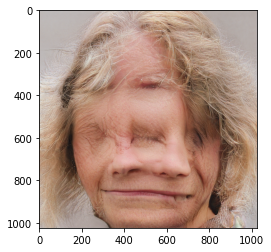

In [10]:
model.rebuild_operations(operations)
y = model.generate_from_vector_fast(latents,is_visualize=False)

plt.imshow(y)


In the next section we'll try different operation on different layers.

### 4.2 Scale  

<img src='./Examples/scale_map.png' width=800></img>  
Scale operation applied on feature maps after resolution 32, Conv1

In [3]:
operations = [{'resolution':4,
               'install_after':'Conv0_up',
               'layers':[{'operation':'none',
                            'name':'01',
                            'scale':0,
                            'with_norm':True}]
               },
              {'resolution':4,
                'install_after':'Conv1',
                'layers':[{'operation':'none',
                            'name':'02',
                            'scale':0,
                            'with_norm':True}]
               },
              {'resolution':8,
                'install_after':'Conv0_up',
                'layers':[{'operation':'none',
                            'name':'03',
                            'scale':0,
                            'with_norm':True}]
               },
              {'resolution':8,
                'install_after':'Conv1',
                'layers':[{'operation':'none',
                            'name':'04',
                            'scale':0,
                            'with_norm':True}]
               },
              {'resolution':16,
                'install_after':'Conv0_up',
                'layers':[{'operation':'none',
                            'name':'05',
                            'scale':0,
                            'with_norm':True}]
               },
              {'resolution':16,
                'install_after':'Conv1',
                'layers':[{'operation':'none',
                            'name':'06',
                            'scale':0,
                            'with_norm':True}]
               },
              {'resolution':32,
                'install_after':'Conv0_up',
                'layers':[{'operation':'none',
                            'name':'07',
                            'scale':0,
                            'with_norm':True}]
               },
              {'resolution':32,
                'install_after':'Conv1',
                'layers':[{'operation':'none',
                            'name':'08',
                            'scale':0,
                            'with_norm':True}]
               },
              ]

In [ ]:
layer_indexes = [6,6,6,6,6]
scale_factor=[-12,-6,0,6,8]
fig,axs = plt.subplots(1,5,figsize=(24,4))
count = 0

for i in range(5):
    operations[layer_indexes[i]]['layers'][0]['scale'] = scale_factor[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'scale'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} scale: {scale_factor[i]}')
    axs[count].imshow(img)
    
    operations[layer_indexes[i]]['layers'][0]['scale'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()
    

<img src='./Examples/scale_g_1.png'></img>  
<img src='./Examples/scale_g_2.png'></img>  
<img src='./Examples/scale_g_4.png'></img>  
<img src='./Examples/scale_g_6.png'></img>  

### 4.3 Invert    

In [ ]:
layer_indexes = [0,1,2,3,4,5,6]
#scale_factor=[-12,-6,0,6,8]
fig,axs = plt.subplots(1,7,figsize=(24,4))
count = 0

for i in range(7):
    #operations[layer_indexes[i]]['layers'][0]['scale'] = scale_factor[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'invert'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} invert')
    axs[count].imshow(img)
    
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/03_invert_g.png'></img>  

### 4.4 Shuffle  

In [ ]:
layer_indexes = [0,1,2,3,4,5,6]
#scale_factor=[-12,-6,0,6,8]
fig,axs = plt.subplots(1,7,figsize=(24,4))
count = 0

for i in range(7):
    #operations[layer_indexes[i]]['layers'][0]['scale'] = scale_factor[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'shuffle'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} shuffle')
    axs[count].imshow(img)
    
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/04_shuffle_g.png'></img>  

### 4.5 Translate    

In [ ]:
layer_indexes = [5,5,5,5,5,5]
factors=[0,2,4,6,8,10]
n=6
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    operations[layer_indexes[i]]['layers'][0]['translateX'] = factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'translate'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} translateX: {factors[i]}')
    axs[count].imshow(img)
    
    operations[layer_indexes[i]]['layers'][0]['translateX'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/05_translate_0.png'></img>  
<img src='./Examples/05_translate_1.png'></img>  
<img src='./Examples/05_translate_2.png'></img>  
<img src='./Examples/05_translate_3.png'></img>  
<img src='./Examples/05_translate_4.png'></img>  

### 4.6 Mean Filter    

In [ ]:
layer_indexes = [4,4,4,4,4]
factors=[2,3,4,5,6]
n=5
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    operations[layer_indexes[i]]['layers'][0]['filter_shape'] = factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'mean_filter'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} mean_filter: {factors[i]}')
    axs[count].imshow(img)
    
    operations[layer_indexes[i]]['layers'][0]['filter_shape'] = 3
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/06_mean_filter_1.png'></img>  
<img src='./Examples/06_mean_filter_2.png'></img>  
<img src='./Examples/06_mean_filter_4.png'></img>  

### 4.7 Rotate  

In [ ]:
layer_indexes = [5,5,5,5,5,5]
factors=[10,6,3,2,2.5,1]
n=6
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    operations[layer_indexes[i]]['layers'][0]['rotation'] = np.pi/factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'rotate'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} rotate: pi/{factors[i]}')
    axs[count].imshow(img)
    
    operations[layer_indexes[i]]['layers'][0]['rotation'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/07_rotate_0.png'></img>  
<img src='./Examples/07_rotate_1.png'></img>  
<img src='./Examples/07_rotate_2.png'></img>  
<img src='./Examples/07_rotate_3.png'></img>  
<img src='./Examples/07_rotate_4.png'></img>  
<img src='./Examples/07_rotate_5.png'></img>  

### 4.8 Sharpen

In [ ]:
layer_indexes = [3,4,5,6,7]
factors=[10,10,10,10,10]
n=5
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'sharpen'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} sharpen_factor: {factors[i]}')
    axs[count].imshow(img)
    
    operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/08_sharpen.png'></img>  

### 4.9 Erosion

In [ ]:
layer_indexes = [0,1,2,3,4,5,6,7]
#factors=[10,10,10,10,10]

n=8
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'erosion'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} erosion')
    axs[count].imshow(img)
    
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/09_erosion.png'></img>  

### 4.10 Dilation

In [ ]:
layer_indexes = [0,1,2,3,4,5,6,7]
#factors=[10,10,10,10,10]

n=8
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'dilation'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} dilation')
    axs[count].imshow(img)
    
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/10_dilation.png'></img>  

### 4.11 MirrorY

In [ ]:
layer_indexes = [0,1,2,3,4,5,6,7]
#factors=[10,10,10,10,10]

n=8
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'mirrorY'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} mirrorY')
    axs[count].imshow(img)
    
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/11_mirrorY.png'></img>  

### 4.12 MirrorX

In [ ]:
layer_indexes = [0,1,2,3,4,5,6,7]
#factors=[10,10,10,10,10]

n=8
fig,axs = plt.subplots(1,n,figsize=(24,6))
count = 0

for i in range(n):
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = factors[i]
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'mirrorX'
    model.rebuild_operations(operations)
    img = model.generate_from_vector_fast(latents,is_visualize=False)
    
    axs[count].axis('off')
    axs[count].title.set_text(f'layer: {layer_indexes[i]} mirrorX')
    axs[count].imshow(img)
    
    #operations[layer_indexes[i]]['layers'][0]['sharpen_factor'] = 0
    operations[layer_indexes[i]]['layers'][0]['operation'] = 'none'
    count += 1
    clear_session()

<img src='./Examples/12_mirrorX.png'></img>  